In [1]:
# Импортируем библиотеки и задаем настройки отображения
import pandas as pd
import pandahouse as ph

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pingouin as pg
from scipy import stats as st
from scipy.stats import norm

import requests
from urllib.parse import urlencode

sns.set(
    style="whitegrid",
    rc={'figure.figsize': (20, 7)})
pd.set_option('display.precision', 2)

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# сделаем функцию для открытия файлов из яндекс диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
def read_yandex(link, sep):
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    return pd.read_csv(download_url, sep = sep)

#загружаем данные
groups = read_yandex('https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';')
groups_add = read_yandex('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ',')
active_studs =  read_yandex('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ',')
checks = read_yandex('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';')

Посмотрим на данные и проверим все ли с ними в порядке 

In [3]:
groups.info()
print('\n')
groups_add.info()
print('\n')
active_studs.info()
print('\n')
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Coun

Объеденим groups и groups_add , так как второй дополняет первый и сделать это вполне логично

In [4]:
total_groups = pd.concat([groups, groups_add])
total_groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [5]:
#Посмотрим какое количество людей в группе А и B
print('A:', 
      total_groups.grp.value_counts()[1],
      '\nB:',
      total_groups.grp.value_counts()[0],
      '\nВсего:',
      total_groups.grp.value_counts()[1]  +  total_groups.grp.value_counts()[0])

A: 14693 
B: 59883 
Всего: 74576


Посмотрим есть ли какие-то аномалии в таблице checks

In [7]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [8]:
paid_not_active = checks.query('student_id not in @active_studs.student_id')
paid_not_active.shape[0]

149

Как мы видим имеются 149 пользователей, которые оплатили, но не пользовались сервисом в дни поведения теста.

Возможно это связано с автооплатой подписки или другим условиями. Возможно это сбой сисетмы. В любом случае нам стоит учитывать только тех пользователей, которые были активные в дни проведения теста и провели оплату.

Объединим список активных пользователей со списком оплативших, отбросив из последних тех, кого нет в списке активных:

In [9]:
active_checks = (
                active_studs
                .merge(checks, how='left', on='student_id')
                .rename(columns={'student_id': 'id'})
                )
active_checks.head()

,id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN


In [10]:
#объеденим active_checks с total_groups, чтобы разделить их по группам
active_total = total_groups.merge(active_checks, how='right', on='id')
active_total.head()
#заполним NaN нулями в столбце rev
active_total['rev'] = active_total.rev.fillna(0)
active_total.head()

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


 Гипотеза 0: значения по выручке на платящего пользователя в двух группах отличаются

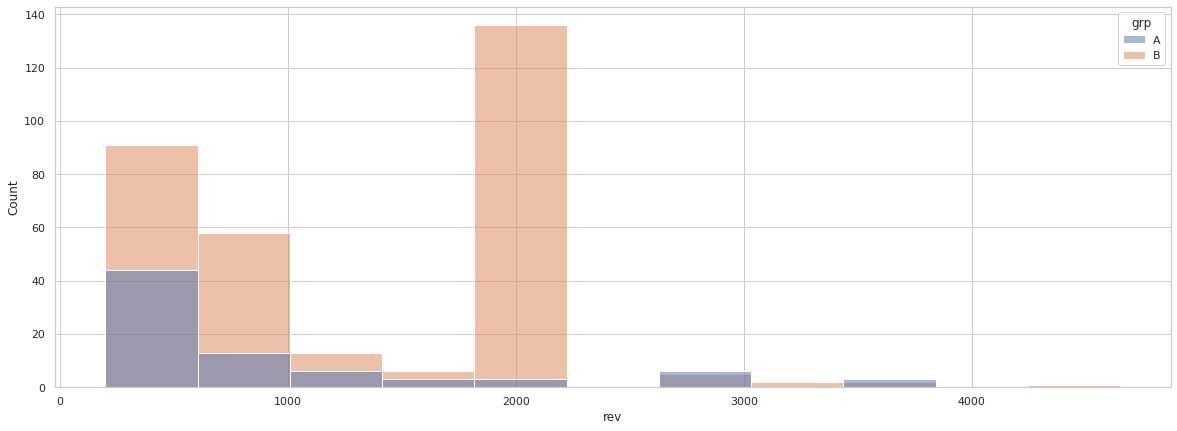

In [11]:
sns.histplot(data = active_total.query('rev>0'), x='rev', hue='grp')

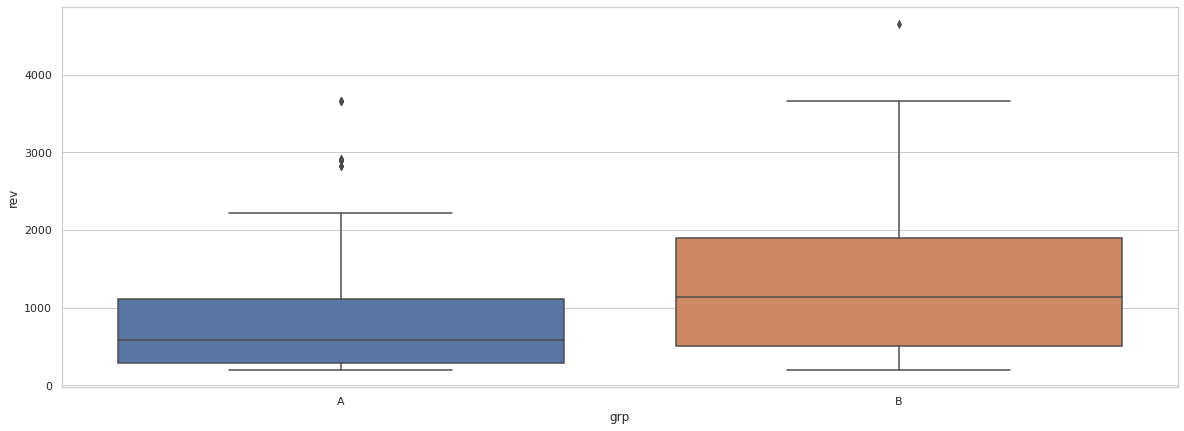

In [12]:
sns.boxplot(data = active_total.query('rev>0'), x='grp', y='rev')

По гистаграммам можно увидеть, что распределение не нормальное. Поэтому мы не можем точно доверять нашим данным. 

Кажется, что покупательная способность выросла. Проверим стат.занчимо ли это. Для этого воспользуемся меодом Bootstrap

In [13]:
pg.compute_bootci(active_total.query('rev>0 and grp == "A"')['rev'],
              active_total.query('rev>0 and grp == "B"')['rev'],
             func=lambda x,y: np.median(x) - np.median(y))

array([-1320.  ,  -191.98])

In [14]:
grA = active_total.query('rev>0 and grp == "A"')[['id','rev']]
grB = active_total.query('rev>0 and grp == "B"')[['id','rev']]

In [15]:
from tqdm.auto import tqdm

def get_bootstrap(data_column_1, data_column_2, iterations=15000, statistic=np.mean, sign_level=0.05):
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data, samples_1_a, samples_2_a = [], [], []

    # Bootstrap sampling
    for _ in tqdm(range(iterations)):
        sample_1 = data_column_1.sample(boot_len, replace=True).values
        sample_2 = data_column_2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(sample_2 - sample_1))
        samples_1_a.append(np.mean(sample_1))
        samples_2_a.append(np.mean(sample_2))

    # Calculate quantiles
    quants = pd.DataFrame(boot_data).quantile([sign_level / 2, 1 - sign_level / 2])

    # Calculate p-values
    boot_mean, boot_std = np.mean(boot_data), np.std(boot_data)
    p_1 = norm.cdf(0, boot_mean, boot_std)
    p_2 = norm.cdf(0, -boot_mean, boot_std)
    p_value = min(p_1, p_2) * 2

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), dpi=100)
    
    # Plot 1
    axes[0].grid(True, linestyle='-', linewidth=0.7, color='lightgrey')
    axes[0].set_facecolor('white')
    n, _, bars = axes[0].hist(boot_data, bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('palevioletred')
        else: 
            bar.set_facecolor('deepskyblue')
        bar.set_edgecolor('purple')

    axes[0].vlines(boot_mean, ymin=0, ymax=max(n),linestyle='-', color='purple',linewidth=0.7)   
    axes[0].vlines(quants,ymin=0,ymax=max(n),linestyle='--', color='purple',linewidth=0.7)
    axes[0].annotate(f"{quants.iloc[0][0]:.3f}", xy=(quants.iloc[0][0], 0), xytext=(quants.iloc[0][0]+.001, max(n)/2))
    axes[0].annotate(f"{quants.iloc[1][0]:.3f}", xy=(quants.iloc[1][0], 0), xytext=(quants.iloc[1][0]+.001, max(n)/2))
    axes[0].set(xlabel='boot_data', ylabel='Frequency', title=f'Distribution of differences in {statistic.__name__}s')
    
    # Plot 2
    axes[1].grid(True, linestyle='-', linewidth=0.7, color='lightgrey')
    axes[1].set_facecolor('white')
    axes[1].hist(samples_1_a, bins=50, color='deepskyblue', alpha=0.5, label=f"{statistic.__name__}s of boot dataset 1")
    axes[1].hist(samples_2_a, bins=50, color='crimson', alpha=0.5, label=f"{statistic.__name__}s of boot dataset 2")
    axes[1].set(ylabel='Frequency')
    axes[1].legend()
    plt.subplots_adjust(hspace=0.2)

    # Result
    conclusion = "reject" if p_value <= sign_level else "fail to reject"
    print(f"The p-value of {np.round(p_value, 6)} suggests that there is evidence to {conclusion} the null hypothesis at the {sign_level} significance level.")

    return {'quants': quants, 'boot mean': boot_mean, 'p_value': p_value}


The p-value of 2.3e-05 suggests that there is evidence to reject the null hypothesis at the 0.05 significance level.


{'quants':           0
 0.03  224.5
 0.97  565.0,
 'boot mean': 400.06473922,
 'p_value': 2.2673337330028417e-05}

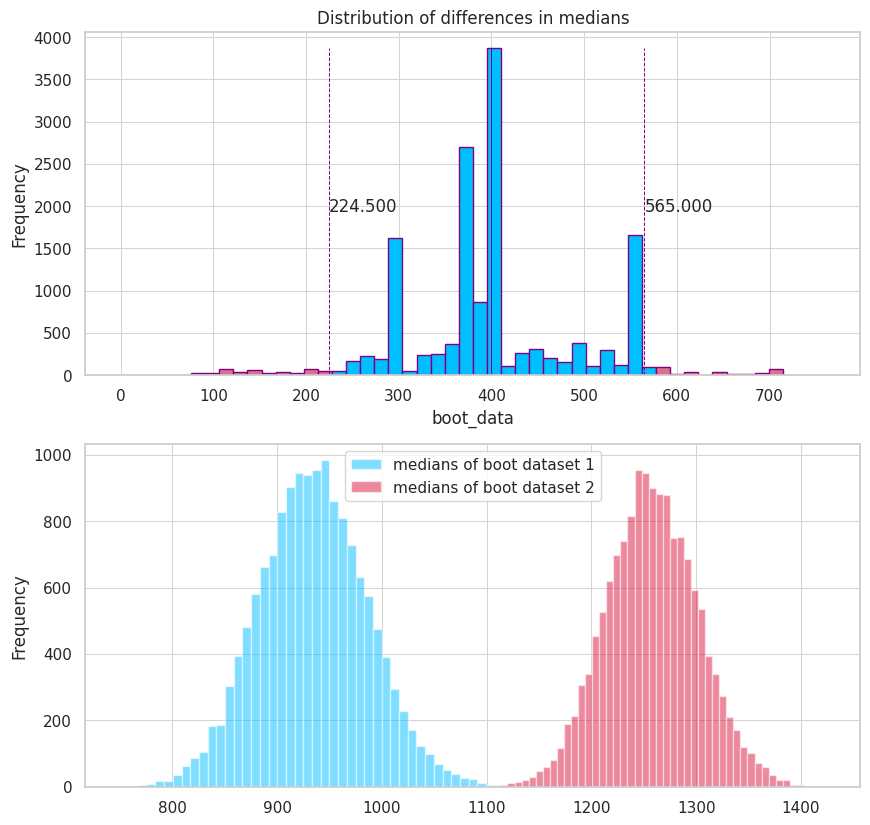

In [16]:
get_bootstrap(grA['rev'],grB['rev'],statistic=np.median) 

Как мы видим значения стат.значимо различаются, поэтому стоит ввести новый метод оплаты 